In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from dolo import yaml_import, approximate_controls, display
from dolo.algos.dtcscc import perfect_foresight as pf
import numpy as np

# Declare plotting style
from matplotlib import pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline
# pd.options.display.mpl_style='default' # deprecated

## RMT4 Figure 11.9.1

In [2]:
model = yaml_import("../models/Figv4_1191.yaml")
T = 101  # simulation length
p_T = 40  # Periods to plot
g = np.ones(T + 1) * .4
g[:9] = 0.2
g_shock=g
# g_shock = g[:100][:,None]   # NEW
# g_shock = {'z': [0.2]*10 + [0.4]}
sol = pf.deterministic_solve(model, shocks=g_shock, T=T, ignore_constraints=True)
# sol['g'] = g  # NEW: not necessary anymore

Model type detected as 'dtcscc'
Missing model name. Set as 'anonymous'


In [3]:
sol_ref = pf.deterministic_solve(model, shocks=[0.2], T=T, ignore_constraints=True)


In [4]:
from dolo.algos.dtcscc.steady_state import find_deterministic_equilibrium
ss = find_deterministic_equilibrium(model, {'g': 0.2})  # new API
ss

OrderedDict([('parameters',
              array([ 0.95,  2.  ,  0.2 ,  0.33,  1.  ,  0.  ,  0.  ])),
             ('controls', array([ 0.64264525])),
             ('shocks', array([ 0.2])),
             ('states', array([ 1.48995649])),
             ('auxiliaries', array([ 0.25263158,  0.76422649,  1.05263158]))])

In [5]:
# suboptimal:  there should be an option in `find_deterministic_equilibrium`
# to return a dict of parameter values instead

from dolo.compiler.misc import calibration_to_dict
ss_d = calibration_to_dict(model, ss)
ss_d

OrderedDict([('beta', 0.94999999999999996),
             ('gamma', 2.0),
             ('delta', 0.20000000000000001),
             ('alpha', 0.33000000000000002),
             ('A', 1.0),
             ('tau_c', 0.0),
             ('tau_k', 0.0),
             ('c', 0.64264525131096106),
             ('g', 0.20000000000000001),
             ('k', 1.4899564934347784),
             ('eta', 0.25263157894736843),
             ('w', 0.76422648849860408),
             ('R', 1.0526315789473684)])

In [6]:
# Compute initial steady states
kbar, cbar = [ss_d['k'], ss_d['c']]
# a = model.functions['auxiliary'] # not necessary anymore
etabar, wbar, Rbar = [ss_d[e] for e in ['eta', 'w', 'R']]
# etabar, wbar, Rbar = a(kbar, cbar, model.calibration['parameters'])

In [7]:
# Set up plotting materials 
o = np.ones(p_T)
names = [['k', 'c', 'R'], ['eta', 'g', 'w']]
titles = [['k', 'c', r'$\bar{R}$'], [r'$\eta$', 'g', 'w']]
ss = [[kbar, cbar, Rbar], [etabar, g[0], wbar]]

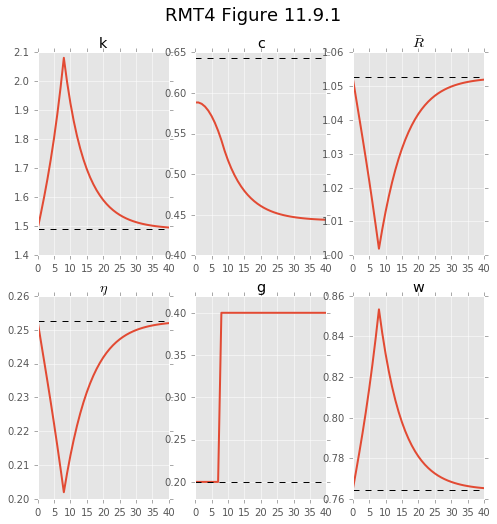

In [8]:
# Generate plots
psol = sol.ix[:p_T]
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(8, 8))
for ind_i, i in enumerate(names):
    for ind_k, k in enumerate(i):
        ax_ik = axes[ind_i, ind_k]
        psol[k].plot(ax=ax_ik, linewidth=2, title=titles[ind_i][ind_k])
        ax_ik.plot(o * ss[ind_i][ind_k], 'k--')
axes[1,1].set_ybound(.18, .42)
fig.suptitle('RMT4 Figure 11.9.1', fontsize=18)

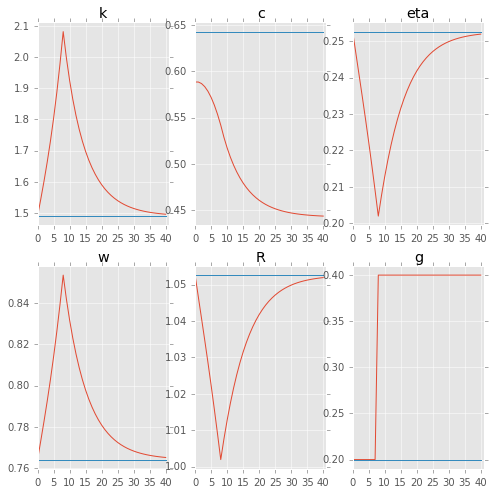

In [11]:
# There is a function to produce the same kind of graphs easily
from dolo.misc.graphs import plot_irfs
fig = plot_irfs([psol, sol_ref])

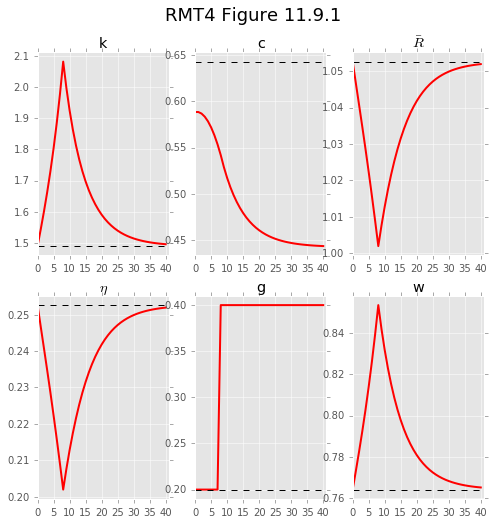

In [12]:
# one can add some options to make it look exactly like the former graph
fig = plot_irfs([psol, sol_ref],
                variables=['k','c','R','eta','g', 'w'],
                line_options=[
                    {'color':'red','linewidth':2},
                    {'color':'black', 'linestyle':'--'}
                ],
                titles=['k', 'c', r'$\bar{R}$', r'$\eta$', 'g', 'w']
            )
fig.suptitle('RMT4 Figure 11.9.1', fontsize=18)

## RMT4 Figure 11.9.2

In [8]:
# Change gamma and compute solution again
model.set_calibration('gamma', 0.2)
sol2 = pf.deterministic_solve(model, shocks=g_shock, T=T, ignore_constraints=True)
# sol2['g'] = g

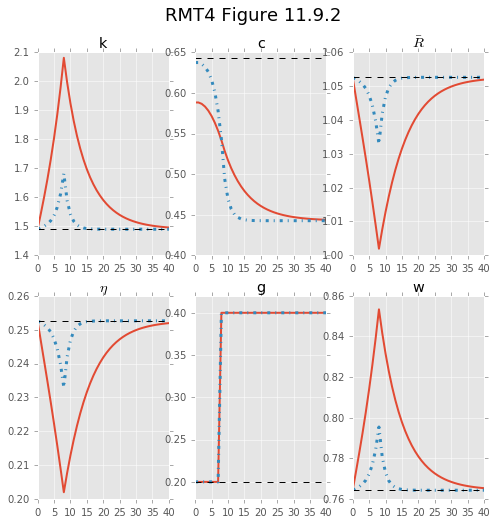

In [9]:
# Generate plot
psol2 = sol2.ix[:p_T]
fig2, axes2 = plt.subplots(nrows=2, ncols=3, figsize=(8, 8))
for ind_i, i in enumerate(names):
    for ind_k, k in enumerate(i):
        ax_ik = axes2[ind_i, ind_k]
        psol[k].plot(ax=ax_ik, linewidth=2, title=titles[ind_i][ind_k])
        psol2[k].plot(ax=ax_ik, linewidth=3, style='-.')
        ax_ik.plot(o * ss[ind_i][ind_k], 'k--')
axes2[1,1].set_ybound(.18, .42)
fig2.suptitle('RMT4 Figure 11.9.2', fontsize=18)

## RMT4 Figure 11.9.3

In [10]:
model.set_calibration('gamma', 2.0)
beta, gamma = model.get_calibration('beta'), 2.0
n = np.arange(1, sol.shape[0] + 1)

# Compute q and qbar
q = beta ** n  * sol['c'] ** (-gamma)  / (beta ** 2 * sol['c'][1] ** (-gamma))
qbar = beta ** (n - 1)
sol['q'] = q
sol['qbar'] = qbar

# Compute r and rbar
sol['r'] = sol['R'] - 1
rbar = sol['R'][0] - 1

# comupte r_{t, s+t}
rst = np.zeros((40, 62))
for t in range(62):
    for i in range(40):
        rst[i, t] = np.log(q[i+t]/  q[t]) / (-i)      

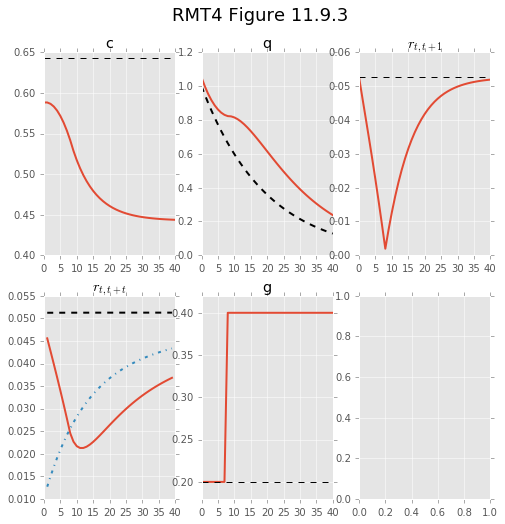

In [11]:
fig3, axes3 = plt.subplots(nrows=2, ncols=3, figsize=(8, 8))
psol3 = sol.ix[:p_T]
psol3['c'].plot(ax=axes3[0,0], linewidth=2, title='c'); axes3[0,0].plot(o * cbar, 'k--')
psol3[['q', 'qbar']].plot(ax=axes3[0,1], linewidth=2, title='q', legend=None, style=['-', 'k--'])
psol3['r'].plot(ax=axes3[0,2], linewidth=2, title=r'$r_{t, t+1}$'); axes3[0,2].plot(o * rbar, 'k--')
axes3[1,0].plot(range(p_T), rst[:, 1], range(p_T), rst[:, 10], '-.', range(p_T), rst[:, -1], 'k--', linewidth=2)
axes3[1, 0].set_title(r'$r_{t, t+t}$')
psol3['g'].plot(ax=axes3[1,1], linewidth=2, title='g'); axes3[1,1].plot(o * g[0], 'k--'); axes3[1,1].set_ybound(.18, .42)
fig3.suptitle('RMT4 Figure 11.9.3', fontsize=18)